# Convolutional Neural Networks
This notebook will guide you through the use of the `keras` package to train convolutional neural networks for handwritten digits classification. You are going to use the `mnist` dataset from LeCun et al. 1998.

## Loading the packages

In [ ]:
%pip install tensorflow --upgrade
%pip install keras --upgrade

import numpy as np
from matplotlib import pyplot as pl

from keras.datasets import fashion_mnist
from keras.models import Model
from keras.layers.core import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
from keras.utils import np_utils
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input
from sklearn import metrics as me
from scipy import stats

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


First, create some useful functions

In [1]:
def f1_score(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    
    # Calculate precision and recall for each class
    true_positives = np.diag(confusion_matrix)
    false_positives = np.sum(confusion_matrix, axis=0) - true_positives
    false_negatives = np.sum(confusion_matrix, axis=1) - true_positives
    
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    
    # Compute F1-score for each class
    f1_scores = 2 * (precision * recall) / (precision + recall)
    
    # Compute the average F1-score
    avg_f1_score = np.mean(f1_scores)
    
    return f1_scores, avg_f1_score

def build_grid_of_images(array):
    assert len(array.shape) == 3
    dim_0 = np.sqrt(array.shape[0])
    assert dim_0.is_integer()
    
    temp_out = np.reshape(array, (dim_0, dim_0, array.shape[1], array.shape[2]))
    temp_out = np.rollaxis(temp_out, 1, 3)
    return np.reshape(temp_out, (dim_0*array.shape[1], dim_0*array.shape[2]))

def plot_conv_layer_output(temp_out, title):
    temp_to_plot = build_grid_of_images(temp_out)
    pl.imshow(temp_to_plot, interpolation='nearest', cmap=pl.get_cmap('Greys'))
    ax = pl.gca()
    ax.set_xticks(np.arange(-0.5, temp_to_plot.shape[0]+0.5, temp_out.shape[1]))    
    ax.set_yticks(np.arange(-0.5, temp_to_plot.shape[0]+0.5, temp_out.shape[2]))
    pl.grid()
    pl.tick_params(axis='both', which='both', bottom='off', top='off', left='off', right='off', labelbottom='off', labelleft='off')
    pl.title(title)

def plot_dense_layer_output(temp_out, title):
    pl.bar(np.arange(temp_out.shape[1])-0.4, temp_out[0,:])
    pl.xlim(-0.5, temp_out.shape[1])
    pl.grid()
    pl.title(title)

Load the `mnist` dataset and normalize in the range [0, 1]

In [ ]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = X_train.reshape(n_train, height, width, 1).astype('float32')
X_test = X_test.reshape(n_test, height, width, 1).astype('float32')

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

60000 train samples
10000 test samples


In [ ]:
print('X_train.shape = ', X_train.shape)
print('Y_train.shape = ', Y_train.shape)
print('X_test.shape = ', X_test.shape)
print('Y_test.shape = ', Y_test.shape)

X_train.shape =  (60000, 28, 28, 1)
Y_train.shape =  (60000, 10)
X_test.shape =  (10000, 28, 28, 1)
Y_test.shape =  (10000, 10)


Create the CNN and show its architecture

In [ ]:
l0 = Input(shape=(height, width, 1), name='l0')

l1 = Conv2D(9, (5, 5), padding='same', activation='relu', name='l1')(l0)
l1_mp = MaxPooling2D(pool_size=(2, 2), name='l1_mp')(l1)

l2 = Conv2D(9, (5, 5), padding='same', activation='relu', name='l2')(l1_mp)
l2_mp = MaxPooling2D(pool_size=(2, 2), name='l2_mp')(l2)

l3 = Conv2D(16, (3, 3), padding='same', activation='relu', name='l3')(l2_mp)
l3_mp = MaxPooling2D(pool_size=(2, 2), name='l3_mp')(l3)

flat = Flatten(name='flat')(l3_mp)

l4 = Dense(15, activation='relu', name='l4')(flat)

l5 = Dense(n_classes, activation='softmax', name='l5')(l4)

model = Model(inputs=l0, outputs=l5)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 l0 (InputLayer)             [(None, 28, 28, 1)]       0         
                                                                 
 l1 (Conv2D)                 (None, 28, 28, 9)         234       
                                                                 
 l1_mp (MaxPooling2D)        (None, 14, 14, 9)         0         
                                                                 
 l2 (Conv2D)                 (None, 14, 14, 9)         2034      
                                                                 
 l2_mp (MaxPooling2D)        (None, 7, 7, 9)           0         
                                                                 
 l3 (Conv2D)                 (None, 7, 7, 16)          1312      
                                                                 
 l3_mp (MaxPooling2D)        (None, 3, 3, 16)          0   

Define some constants and train de CNN

In [ ]:
batch_size = 128
n_epoch = 20

model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epoch, verbose=1, validation_split=0.1)

Epoch 1/20
422/422 [==============================] - 4s 5ms/step - loss: 0.8363 - accuracy: 0.7016 - val_loss: 0.5588 - val_accuracy: 0.7885
Epoch 2/20
422/422 [==============================] - 2s 5ms/step - loss: 0.5244 - accuracy: 0.8086 - val_loss: 0.5024 - val_accuracy: 0.8137
Epoch 3/20
422/422 [==============================] - 2s 5ms/step - loss: 0.4539 - accuracy: 0.8356 - val_loss: 0.4413 - val_accuracy: 0.8362
Epoch 4/20
422/422 [==============================] - 2s 5ms/step - loss: 0.4110 - accuracy: 0.8519 - val_loss: 0.4135 - val_accuracy: 0.8468
Epoch 5/20
422/422 [==============================] - 2s 5ms/step - loss: 0.3804 - accuracy: 0.8630 - val_loss: 0.3683 - val_accuracy: 0.8645
Epoch 6/20
422/422 [==============================] - 2s 6ms/step - loss: 0.3579 - accuracy: 0.8704 - val_loss: 0.3689 - val_accuracy: 0.8622
Epoch 7/20
422/422 [==============================] - 2s 5ms/step - loss: 0.3429 - accuracy: 0.8757 - val_loss: 0.3867 - val_accuracy: 0.8573
Epoch 

Show the performance of the model

Test score: 0.307561457157135
Test accuracy: 0.890999972820282


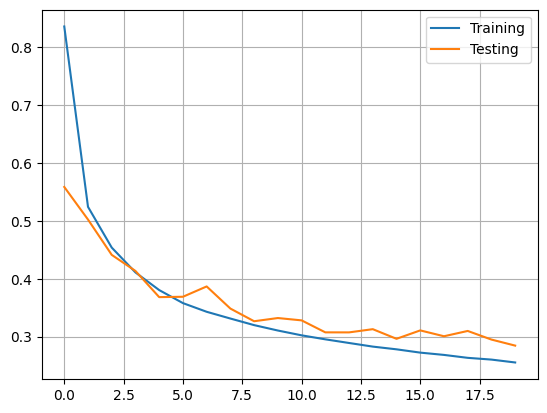

In [ ]:
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Testing')
pl.legend()
pl.grid()

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Confusion matrix

In [ ]:

pred = model.predict(X_test)
print('pred.shape = ', pred.shape)
pred = np.argmax(pred, axis=-1)
me.confusion_matrix(y_test, pred)

313/313 [==============================] - 1s 2ms/step
pred.shape =  (10000, 10)


array([[859,   0,  21,  31,   5,   1,  68,   0,  15,   0],
       [  0, 965,   1,  26,   2,   0,   4,   0,   2,   0],
       [ 16,   2, 838,  11,  83,   0,  49,   0,   1,   0],
       [ 18,   3,  12, 918,  27,   0,  18,   0,   4,   0],
       [  1,   2,  71,  31, 850,   1,  39,   0,   5,   0],
       [  0,   0,   0,   0,   0, 973,   0,  17,   1,   9],
       [158,   3,  88,  30,  92,   0, 619,   0,  10,   0],
       [  0,   0,   0,   0,   0,  13,   0, 961,   1,  25],
       [  2,   0,   3,   4,   3,   2,   2,   4, 980,   0],
       [  1,   0,   0,   0,   0,   8,   0,  44,   0, 947]])